## Customer Segmentation
We will be using E-commerce dataset of user purchases and try develop a model that allow us to do two things:
- Classifying customers into segments.
- Anticipate the purchases that will be made by a new customer, during the following year and this, from its first purchase by assigning them appropriate cluster/segment

## Import packages

In [1]:
# from __future__ import division
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
#import plotly.plotly as py
#import plotly.graph_objs as go
#from plotly.offline import init_notebook_mode,iplot
#init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

## Data Preparation

In [2]:
# df_initial = pd.read_csv('https://raw.githubusercontent.com/firmai/python-business-analytics/master/data/customer/data.csv',encoding="ISO-8859-1",
#                          dtype={'CustomerID': str,'InvoiceID': str})
df_initial = pd.read_csv('/Users/hongyingyue/Git/python-business-analytics/data/customer/data.csv',encoding="ISO-8859-1")
print('Dataframe dimensions:', df_initial.shape)
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

Dataframe dimensions: (284709, 8)


In [3]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,559518,21989,PACK OF 20 SKULL PAPER NAPKINS,6,2011-07-08 16:11:00,1.63,NaN,United Kingdom
1,559518,22055,MINI CAKE STAND HANGING STRAWBERY,1,2011-07-08 16:11:00,3.29,NaN,United Kingdom
2,559518,22179,SET 10 NIGHT OWL LIGHTS,1,2011-07-08 16:11:00,13.29,NaN,United Kingdom
3,559518,22297,HEART IVORY TRELLIS SMALL,1,2011-07-08 16:11:00,2.46,NaN,United Kingdom
4,559518,22352,LUNCH BOX WITH CUTLERY RETROSPOT,1,2011-07-08 16:11:00,4.96,NaN,United Kingdom


## EDA

### Identify null values

In [4]:
# gives some infomation on columns types and number of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(round(df_initial.isnull().sum()/df_initial.shape[0]*100,2)).T.
                         rename(index={0:'null values (%)'}))
print ('-' * 10 + " Display information about column types and number of null values " + '-' * 10 )
print 
display(tab_info)

---------- Display information about column types and number of null values ----------


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,float64,object
null values (nb),0,0,502,0,0,0,61357,0
null values (%),0.0,0.0,0.18,0.0,0.0,0.0,21.55,0.0


Note:
- If you are looking to the CustomerID column then there are  ∼ 25% data entries are null.
- That means there are  ∼ 25% of data entries which aren't assigned to any customer(s).
- It is impossible for us to map values for the customer and these entries. These are usless for the current exercise.

Because of all the above points we are deleting these data entries.

### Remove data entries

In [5]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
# gives some information on columns types and number of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(round(df_initial.isnull().sum()/df_initial.shape[0]*100,2)).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (223352, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,float64,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
print('Duplicate data entries: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicate data entries: 3175


## Explore data attributes

### Country

In [7]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(
    ['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('No. of cuntries in dataframe: {}'.format(len(countries)))

No. of cuntries in dataframe: 32


In [8]:
temp_no_of_order_per_count = df_initial[['CustomerID','Country']].groupby(['Country']).count()
temp_no_of_order_per_count = temp_no_of_order_per_count.reset_index(drop = False)

print('-' * 10 + " Contry-wise order calculation "+ '-' * 10)
print
print (temp_no_of_order_per_count.sort_values(
    by='CustomerID', ascending=False).rename(index=str,
                                        columns={"CustomerID": "Country wise number of order"}))

---------- Contry-wise order calculation ----------
                 Country  Country wise number of order
30        United Kingdom                        195468
12               Germany                          5020
11                France                          4633
8                   EIRE                          4592
25                 Spain                          1326
19           Netherlands                          1126
27           Switzerland                          1095
2                Belgium                          1072
22              Portugal                           847
20                Norway                           708
0              Australia                           587
16                 Italy                           491
4        Channel Islands                           389
10               Finland                           363
1                Austria                           274
28                   USA                           269
5            

### Customers and Products

In [9]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], 
              index = ['quantity'])

,products,transactions,customers
quantity,3182,11068,3341


In [10]:
# to explore the number of products purchased in every transaction
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12347.0,562032,22
1,12347.0,573511,47
2,12347.0,581180,11
3,12348.0,568172,3
4,12349.0,577609,73
5,12352.0,567505,18
6,12352.0,568699,14
7,12352.0,574275,15
8,12356.0,576895,2
9,12357.0,574740,131


In [11]:
nb_products_per_basket[nb_products_per_basket['Number of products']==1].head(3)

,CustomerID,InvoiceNo,Number of products
33,12371.0,572770,1
38,12375.0,C581071,1
44,12380.0,C572532,1


Points to be noted here:
- There are some users who only came one time on the E-commerce platform and purchased one item. The example of this kind of user is customerID 12371.
- There are some users who frequently buy large number of items per order. The example of this kind of user is customerID 12357.
- If you notice InvoiceNo data attribute then you can find out that there is prefix 'C' for one invoice. This 'C' indicates that the particular transaction has been cancelled.

### Cancelled orders
We need to count the number of transactions corresponding to cancelled orders

In [12]:
nb_products_per_basket['order_cancelled'] = nb_products_per_basket['InvoiceNo'].apply(
    lambda x:int('C' in x))
display(nb_products_per_basket[38:45])

n1 = nb_products_per_basket['order_cancelled'].sum()
n2 = nb_products_per_basket.shape[0]
percentage = (n1/n2)*100
print('Number of orders cancelled: {}/{} ({:.2f}%) '.format(n1, n2, percentage))

,CustomerID,InvoiceNo,Number of products,order_cancelled
38,12375.0,C581071,1,1
39,12378.0,562046,219,0
40,12379.0,567196,20,0
41,12380.0,567928,28,0
42,12380.0,571187,23,0
43,12380.0,577180,17,0
44,12380.0,C572532,1,1


Number of orders cancelled: 1686/11068 (15.23%) 


In [13]:
# to check if there is systematically an order indicating the same quantity (but positive), 
# with the same description (CustomerID, Description and UnitPrice)
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID                         14808.0
Quantity                                -1
StockCode                            22655
Description    VINTAGE RED KITCHEN CABINET
UnitPrice                            125.0
Name: 279, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [14]:
# because of the existence of a 'Discount' entry
# to check again the hypothesis but this time discarding the 'Discount' entries
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

279 CustomerID                         14808.0
Quantity                                -1
StockCode                            22655
Description    VINTAGE RED KITCHEN CABINET
UnitPrice                            125.0
Name: 279, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


Once more, the initial hypothesis is not verified. 
Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.

In [15]:
# to create a new variable in the dataframe that indicate if part of the command has been canceled
# For the cancellations without counterparts, a few of them are probably due to the fact that 
# the buy orders were performed before December 2010 (the point of entry of the database). 
# Below, to make a census of the cancel orders and check for the existence of counterparts:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()

    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
   
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
   
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In the above function, I checked the two cases:
- a cancel order exists without counterpart
- there's at least one counterpart with the exact same quantity

The index of the corresponding cancel order are respectively kept in the doubtfull_entry and entry_to_remove lists whose sizes are:

In [16]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 3424
doubtfull_entry: 984


In [17]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries

nb of entries to delete: 10


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
76464,C566209,23355,HOT WATER BOTTLE KEEP CALM,-5,2011-09-09 15:04:00,4.95,16362.0,United Kingdom,0
80564,C566467,22384,LUNCH BAG PINK POLKADOT,-14,2011-09-12 18:04:00,1.65,14688.0,United Kingdom,0
103337,C568232,23007,SPACEBOY BABY GIFT SET,-3,2011-09-26 11:27:00,16.95,14808.0,United Kingdom,0
165413,C573097,23251,VINTAGE RED ENAMEL TRIM MUG,-18,2011-10-27 14:42:00,1.25,15038.0,United Kingdom,0
177723,C574065,22945,CHRISTMAS METAL TAGS ASSORTED,-24,2011-11-02 14:43:00,0.85,13271.0,United Kingdom,0
183052,C574524,22947,WOODEN ADVENT CALENDAR RED,-2,2011-11-04 13:53:00,7.95,17841.0,United Kingdom,0
259575,C579948,21098,CHRISTMAS TOILET ROLL,-3,2011-12-01 10:56:00,1.25,16376.0,United Kingdom,0
262933,C580263,M,Manual,-4,2011-12-02 12:43:00,9.95,12536.0,France,0
262934,C580263,M,Manual,-16,2011-12-02 12:43:00,0.29,12536.0,France,0
270155,C580708,84946,ANTIQUE SILVER T-LIGHT GLASS,-12,2011-12-05 16:33:00,1.25,14546.0,United Kingdom,0


### StockCode

In [18]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['M', 'POST', 'D', 'C2', 'PADS', 'DOT', 'BANK CHARGES'],
      dtype=object)

In [19]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

M               -> Manual                        
POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                
BANK CHARGES    -> Bank Charges                  


We see that there are several types of peculiar transactions, connected e.g. to port charges or bank charges.

### Basket Price

In [20]:
# to create a new variable that indicates the total price of every purchase
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
171803,573511,22131,FOOD CONTAINER SET 3 LOVE HEART,6,2011-10-31 12:25:00,1.95,12347.0,Iceland,0,11.7
171761,573511,22375,AIRLINE BAG VINTAGE JET SET BROWN,8,2011-10-31 12:25:00,4.25,12347.0,Iceland,0,34.0
171762,573511,22371,AIRLINE BAG VINTAGE TOKYO 78,12,2011-10-31 12:25:00,3.95,12347.0,Iceland,0,47.4
171763,573511,22374,AIRLINE BAG VINTAGE JET SET RED,8,2011-10-31 12:25:00,4.25,12347.0,Iceland,0,34.0
171764,573511,22252,BIRDCAGE DECORATION TEALIGHT HOLDER,12,2011-10-31 12:25:00,1.25,12347.0,Iceland,0,15.0


In [21]:
# to ollect all the purchases made during a single order to recover the total order price

# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# selection of significant entries
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
0,12347.0,562032,584.91,2011-08-02 08:48:00
1,12347.0,573511,1294.32,2011-10-31 12:25:00
2,12347.0,581180,224.82,2011-12-07 15:52:00
3,12348.0,568172,310.00,2011-09-25 13:13:00
4,12349.0,577609,1757.55,2011-11-21 09:51:00
5,12352.0,567505,366.25,2011-09-20 14:34:00


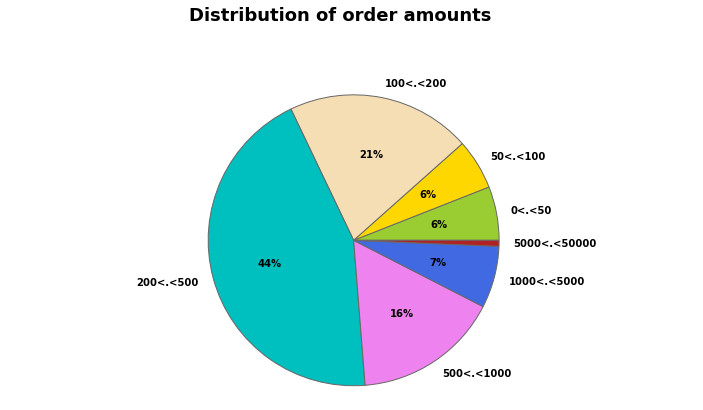

In [22]:
# Purchase count
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

# Representation of the number of purchases / amount       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

## Product categories - nlp application

In [23]:
# to extract from the Description variable the information that will prove useful
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("number of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as input the dataframe and analyzes the content of the Description column by performing the following operations:
- extract the names (proper, common) appearing in the products description
- for each name, extract the root of the word and aggregate the set of names associated with this particular root count the number of times each root appears in the dataframe
- when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

In [24]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

In [25]:
# import ssl
nltk.download('punkt')
# from nltk import punkt
nltk.download('averaged_perceptron_tagger')
# from nltk import averaged_perceptron_tagger

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hongyingyue/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/hongyingyue/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [28]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

number of keywords in variable 'Description': 1347


The execution of this function returns three variables:
- keywords: the list of extracted keywords
- keywords_roots: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
- count_keywords: dictionary listing the number of times every word is used

In [29]:
# to convert the count_keywords dictionary into a list, to sort the keywords according to their occurrence
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

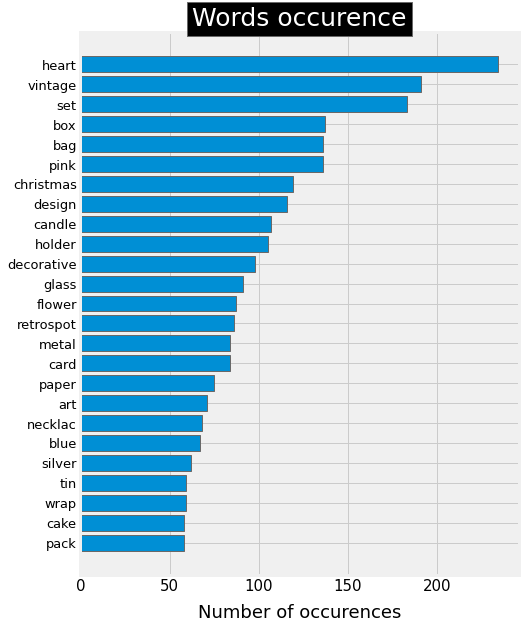

In [32]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 10))
y_axis = [i[1] for i in liste[:25]]
x_axis = [k for k,i in enumerate(liste[:25])]
x_label = [i[0] for i in liste[:25]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

### Define product categories

In [33]:
# to discard color-wise words which are useless
# to consider only the words that appear more than 13 times
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
 
list_products.sort(key = lambda x:x[1], reverse = True)
print('Preserved words:', len(list_products))

Preserved words: 164


#### Data encoding
- whether it's too manual? consider to do it in cut function?

In [37]:
list_products

[['heart', 234],
 ['vintage', 191],
 ['set', 183],
 ['box', 137],
 ['bag', 136],
 ['christmas', 119],
 ['design', 116],
 ['candle', 107],
 ['holder', 105],
 ['decorative', 98],
 ['glass', 91],
 ['flower', 87],
 ['retrospot', 86],
 ['metal', 84],
 ['card', 84],
 ['paper', 75],
 ['art', 71],
 ['necklac', 68],
 ['silver', 62],
 ['tin', 59],
 ['wrap', 59],
 ['cake', 58],
 ['pack', 58],
 ['sign', 58],
 ['star', 55],
 ['mini', 54],
 ['mug', 54],
 ['cover', 53],
 ['polkadot', 52],
 ['wall', 51],
 ['frame', 49],
 ['egg', 49],
 ['home', 49],
 ['garden', 47],
 ['gift', 47],
 ['ivory', 45],
 ['bowl', 45],
 ['ring', 44],
 ['mirror', 43],
 ['tea', 42],
 ['bird', 42],
 ['cushion', 42],
 ['bracelet', 42],
 ['clock', 41],
 ['cream', 41],
 ['paisley', 40],
 ['party', 40],
 ['letter', 40],
 ['ribbon', 38],
 ['bottle', 38],
 ['wood', 37],
 ['drawer', 36],
 ['jar', 35],
 ['pencil', 35],
 ['earrings', 35],
 ['hook', 34],
 ['skull', 34],
 ['garland', 33],
 ['zinc', 32],
 ['water', 32],
 ['bell', 31],
 ['cup

In [34]:
# X matrix
liste_produits = df_cleaned['Description'].unique()
print(liste_produits[0:2])
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
print(X[0:1])

['LUNCH BAG DOLLY GIRL DESIGN' 'LUNCH BAG SUKI DESIGN ']
   heart  vintage  set  box  bag  christmas  design  candle  holder  \
0      0        0    0    0    1          0       1       0       0   

   decorative  ...  picture  bathroom  travel  biscuit  orbit  coaster  table  \
0           0  ...        0         0       0        0      0        0      0   

   purse  tidy  shell  
0      0     0      0  

[1 rows x 164 columns]


- The  𝑋  matrix indicates the words contained in the description of the products using the one-hot-encoding principle.
- In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers. Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

In [38]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    #print(i)
    #print(col)
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    #print (prix)
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [41]:
# to check the number of products in the different groups
print("{:<8} {:<20} \n".format('range', 'number of products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    number of products   
--------------------
0<.<1       890                 
1<.<2       817                 
2<.<3       553                 
3<.<5       520                 
5<.<10      395                 
.>10        123                 


### Create clusters of products

- kmeans method of sklearn uses a Euclidean distance
- kmodes package uses the Hamming's metric - the most suitable metric for the calculation of distances for this case

In [43]:
# In order to define (approximately) the number of clusters that best represents the data
# to use the silhouette score:
matrix = X.values
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.11062930220266365
For n_clusters = 4 The average silhouette_score is : 0.13214080056273358
For n_clusters = 5 The average silhouette_score is : 0.15722360950670058
For n_clusters = 6 The average silhouette_score is : 0.15638595424358195
For n_clusters = 7 The average silhouette_score is : 0.15485749261038476
For n_clusters = 8 The average silhouette_score is : 0.1594477241873311
For n_clusters = 9 The average silhouette_score is : 0.14951577254347373


In practice, the scores obtained above can be considered equivalent since, depending on the run, scores of  0.1±0.05  will be obtained for all clusters with n_clusters  >  3 (we obtain slightly lower scores for the first cluster). On the other hand, I found that beyond 5 clusters, some clusters contained very few elements. I therefore choose to separate the dataset into 5 clusters. 

In order to ensure a good classification at every run of the notebook, I iterate untill we obtain the best possible silhouette score, which is, in the present case, around 0.15:

In [44]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.15783448789713095


### Characterize the content of clusters

In [45]:
# to check the number of elements in each cluster
pd.Series(clusters).value_counts()

3    890
2    817
0    643
4    553
1    395
dtype: int64

#### a: Silhouette intra-cluster score 
In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters. This is the purpose of the next figure which is taken from the sklearn documentation:

In [46]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    #plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        #color = cm.spectral(float(i) / n_clusters) facecolor=color, edgecolor=color,       
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.8)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
       
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

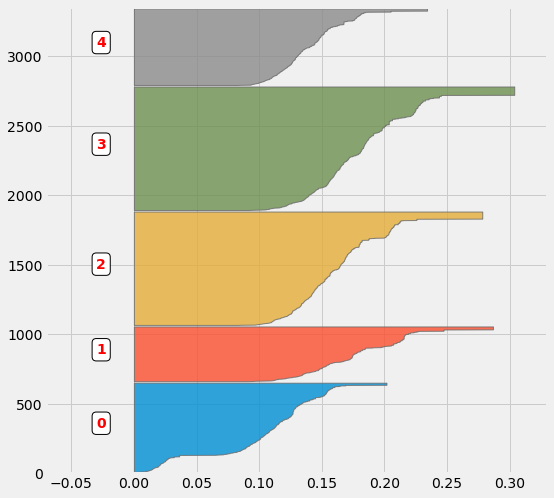

In [47]:
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)

# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

#### b: Word Cloud

Now we can have a look at the type of objects that each cluster represents. In order to obtain a global view of their contents, I determine which keywords are the most frequent in each of them

In [48]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

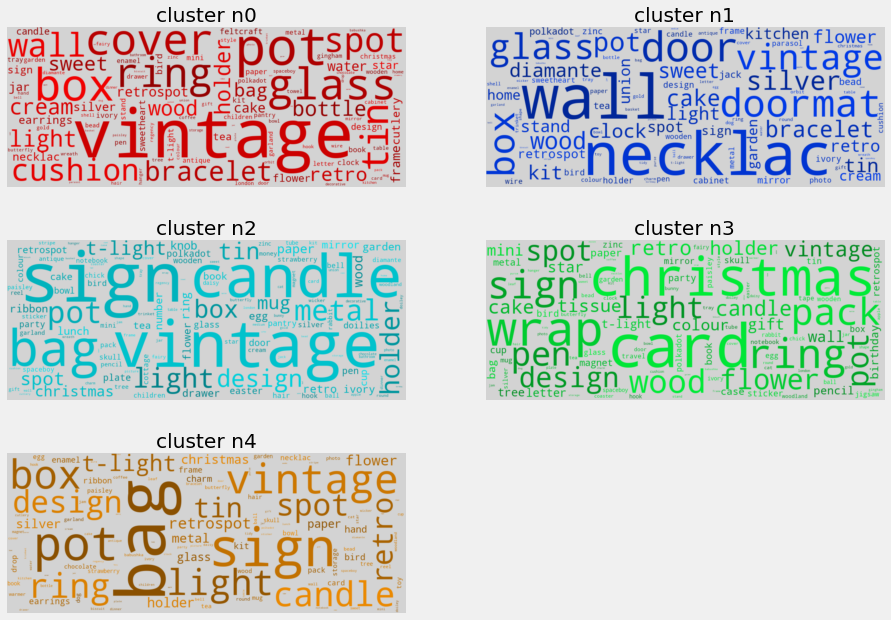

In [49]:
# word cloud
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster n{}'.format(increment-1))

fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)            

From this representation, we can see that for example, one of the clusters contains objects that could be associated with gifts (keywords: Christmas, packaging, card, ...). Another cluster would rather contain luxury items and jewelry (keywords: necklace, bracelet, lace, silver, ...). Nevertheless, it can also be observed that many words appear in various clusters and it is therefore difficult to clearly distinguish them.

#### c: Principal Component Analysis 
In order to ensure that these clusters are truly distinct, I look at their composition. Given the large number of variables of the initial matrix, I first perform a PCA:

In [50]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

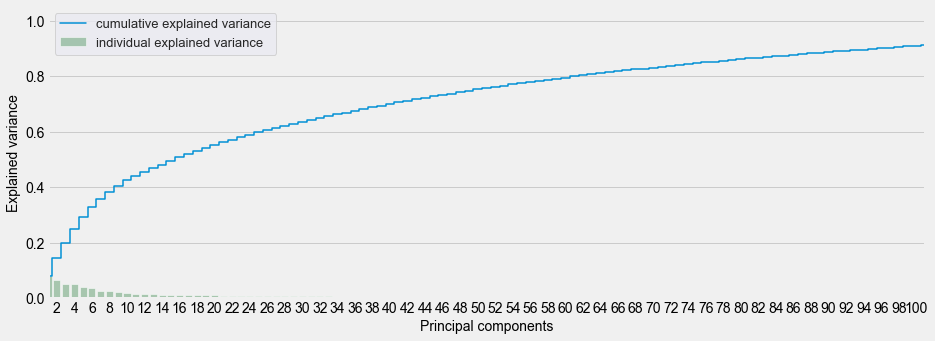

In [51]:
# to check for the amount of variance explained by each component:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

We see that the number of components required to explain the data is extremely important: 
- we need more than 100 components to explain 90% of the variance of the data. 
- In practice, I decide to keep only a limited number of components since this decomposition is only performed to visualize the data:

In [52]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

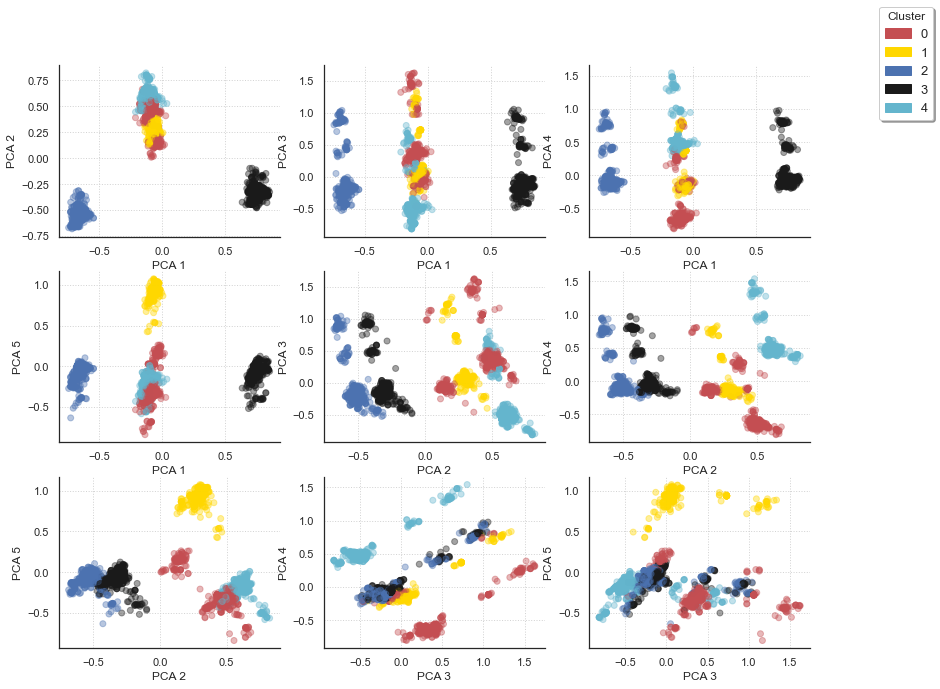

In [61]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 5):    
        increment += 1
        ax = fig.add_subplot(3,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        

comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster',
           shadow = True, frameon = True, framealpha = 1,fontsize = 13, 
           bbox_transform = plt.gcf().transFigure) #facecolor = 'lightgrey',

plt.tight_layout()

In [63]:
mat

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,cluster
0,-0.694697,-0.502086,-0.402304,-0.015647,-0.134920,-0.092387,-0.816641,0.479774,0.925701,0.378548,...,-0.010074,0.032207,0.043513,-0.082191,-0.134388,0.012735,-0.011124,-0.024274,-0.032423,2
1,-0.694697,-0.502086,-0.402304,-0.015647,-0.134920,-0.092387,-0.816641,0.479774,0.925701,0.378548,...,-0.010074,0.032207,0.043513,-0.082191,-0.134388,0.012735,-0.011124,-0.024274,-0.032423,2
2,-0.674510,-0.489401,-0.253615,-0.059912,-0.070607,-0.001700,-0.218243,-0.063465,-0.098406,0.268898,...,-0.024619,0.036682,-0.008114,-0.021937,-0.047483,0.034026,-0.010762,0.027334,-0.021597,2
3,-0.695575,-0.505651,-0.407114,-0.022649,-0.140833,-0.101422,-0.817060,0.505755,0.937406,0.368322,...,0.049323,-0.039281,-0.045769,-0.160917,-0.116195,0.001067,0.028315,-0.007278,-0.107664,2
4,-0.072765,0.474013,0.387358,-0.645470,-0.289963,-0.129002,-0.116561,-0.011103,0.002699,-0.058104,...,-0.099796,0.013136,-0.004420,0.047187,-0.059438,0.012671,0.002792,0.023363,-0.018433,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3293,-0.646045,-0.558774,-0.184385,-0.104285,-0.021724,-0.080581,-0.103700,-0.125739,-0.174591,-0.157256,...,-0.235129,-0.208179,0.211178,-0.321952,0.227186,0.284475,-0.369306,-0.084579,0.057674,2
3294,-0.147561,0.574682,-0.533393,0.417678,-0.241801,-0.236084,0.725165,0.574035,-0.072175,-0.172201,...,-0.040726,-0.001370,-0.019852,-0.168654,0.124954,0.088749,-0.075277,0.076944,-0.023790,4
3295,-0.088227,0.555439,0.314826,-0.684714,-0.346564,-0.261778,-0.179247,-0.097959,-0.352920,0.616939,...,0.000568,-0.084182,-0.028507,0.036935,0.043437,-0.042328,-0.049382,-0.126010,0.137088,0
3296,-0.172223,0.468314,0.704992,1.481137,-0.360227,-0.165667,0.693129,-0.926782,0.790067,0.226740,...,-0.041750,-0.011887,-0.054735,0.035900,0.099933,-0.054533,0.105898,-0.274884,0.259383,4


## Customer categories

### Format data
In the previous section, the different products were grouped in five clusters. In order to prepare the rest of the analysis, a first step consists in introducing this information into the dataframe. To do this, I create the categorical variable categ_product where I indicate the cluster of each product :

In [65]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 

df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)
df_cleaned[['InvoiceNo', 'Description', 'categ_product']][:10]

,InvoiceNo,Description,categ_product
19,559519,LUNCH BAG DOLLY GIRL DESIGN,2
20,559519,LUNCH BAG SUKI DESIGN,2
21,559519,LUNCH BAG CARS BLUE,2
22,559519,LUNCH BAG SPACEBOY DESIGN,2
98,559523,REGENCY CAKE SLICE,0
99,559523,CAKE STAND 3 TIER MAGIC GARDEN,0
100,559523,SET OF 3 HEART COOKIE CUTTERS,2
101,559523,72 SWEETHEART FAIRY CAKE CASES,3
102,559523,TOAST ITS - I LOVE YOU,2
103,559523,RED FLOCK LOVE HEART PHOTO FRAME,3


### Group products
In a second step, I decide to create the categ_N variables (with  𝑁∈[0:4] ) that contains the amount spent in each product category:

In [66]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)


df_cleaned[['InvoiceNo', 'Description', 
            'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:10]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
19,559519,LUNCH BAG DOLLY GIRL DESIGN,2,0.00,0.0,217.50,0.00,0.0
20,559519,LUNCH BAG SUKI DESIGN,2,0.00,0.0,217.50,0.00,0.0
21,559519,LUNCH BAG CARS BLUE,2,0.00,0.0,217.50,0.00,0.0
22,559519,LUNCH BAG SPACEBOY DESIGN,2,0.00,0.0,217.50,0.00,0.0
98,559523,REGENCY CAKE SLICE,0,4.95,0.0,0.00,0.00,0.0
99,559523,CAKE STAND 3 TIER MAGIC GARDEN,0,12.75,0.0,0.00,0.00,0.0
100,559523,SET OF 3 HEART COOKIE CUTTERS,2,0.00,0.0,1.25,0.00,0.0
101,559523,72 SWEETHEART FAIRY CAKE CASES,3,0.00,0.0,0.00,0.55,0.0
102,559523,TOAST ITS - I LOVE YOU,2,0.00,0.0,1.25,0.00,0.0
103,559523,RED FLOCK LOVE HEART PHOTO FRAME,3,0.00,0.0,0.00,0.78,0.0


Up to now, the information related to a single order was split over several lines of the dataframe (one line per product). I decide to collect the information related to a particular order and put in in a single entry. I therefore create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

In [68]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
19,559519,22662,LUNCH BAG DOLLY GIRL DESIGN,150,2011-07-08 16:17:00,1.45,17353.0,United Kingdom,0,217.50,2,0.00,0.0,217.5,0.0,0.0
20,559519,22383,LUNCH BAG SUKI DESIGN,150,2011-07-08 16:17:00,1.45,17353.0,United Kingdom,0,217.50,2,0.00,0.0,217.5,0.0,0.0
21,559519,20728,LUNCH BAG CARS BLUE,150,2011-07-08 16:17:00,1.45,17353.0,United Kingdom,0,217.50,2,0.00,0.0,217.5,0.0,0.0
22,559519,22382,LUNCH BAG SPACEBOY DESIGN,150,2011-07-08 16:17:00,1.45,17353.0,United Kingdom,0,217.50,2,0.00,0.0,217.5,0.0,0.0
98,559523,23164,REGENCY CAKE SLICE,1,2011-07-08 17:19:00,4.95,13955.0,United Kingdom,0,4.95,0,4.95,0.0,0.0,0.0,0.0


In [78]:
# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})


# percentage of the price of the order / product category
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price[col] = temp[col]


# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
0,12347.0,562032,584.91,196.41,97.8,109.70,61.30,119.70,2011-08-02 08:48:00
1,12347.0,573511,1294.32,445.22,55.6,203.30,154.30,435.90,2011-10-31 12:25:00
2,12347.0,581180,224.82,30.00,0.0,80.40,58.98,55.44,2011-12-07 15:52:00
3,12348.0,568172,310.00,40.00,0.0,270.00,0.00,0.00,2011-09-25 13:13:00
4,12349.0,577609,1757.55,641.65,373.2,465.86,79.32,197.52,2011-11-21 09:51:00


### Split of data over time
The dataframe basket_price contains information for a period of 5 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit. In order to be able to test the model in a realistic way, I split the data set by retaining the first 3 months to develop the model and the following two months to test it:

In [79]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2011-07-08 16:17:00 -> 2011-12-09 12:50:00


In [81]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < datetime.datetime(2011,10,1)]
set_test         = basket_price[basket_price['InvoiceDate'] >= datetime.datetime(2011,10,1)]
basket_price = set_entrainement.copy(deep = True)

### Consumer order combinations
In a second step, I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [84]:
# of visits and stats on cart amount / users
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min',
                                                                                   'max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.0,1,584.91,584.91,584.91,584.91,33.579525,16.720521,18.755022,10.480245,20.464687
1,12348.0,1,310.00,310.00,310.00,310.00,12.903226,0.000000,87.096774,0.000000,0.000000
2,12352.0,2,266.25,366.25,316.25,632.50,56.671937,24.561265,16.110672,0.000000,2.656126
3,12358.0,1,484.86,484.86,484.86,484.86,19.593285,66.287176,10.469001,0.000000,3.650538
4,12360.0,1,534.70,534.70,534.70,534.70,36.955302,0.000000,12.537872,8.857303,41.649523


Finally, I define two additional variables that give the number of days elapsed since the first purchase (** FirstPurchase ) and the number of days since the last purchase ( LastPurchase **):

In [85]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347.0,1,584.91,584.91,584.91,584.91,33.579525,16.720521,18.755022,10.480245,20.464687,59,59
1,12348.0,1,310.00,310.00,310.00,310.00,12.903226,0.000000,87.096774,0.000000,0.000000,5,5
2,12352.0,2,266.25,366.25,316.25,632.50,56.671937,24.561265,16.110672,0.000000,2.656126,2,10
3,12358.0,1,484.86,484.86,484.86,484.86,19.593285,66.287176,10.469001,0.000000,3.650538,80,80
4,12360.0,1,534.70,534.70,534.70,534.70,36.955302,0.000000,12.537872,8.857303,41.649523,42,42


A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. In part, I find that this type of customer represents 1/3 of the customers listed:

In [86]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("No. customers with single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

No. customers with single purchase: 1227/2058  (59.62%)


### Creation of customer categories

#### Data encoding

In [87]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].values

In [88]:
# to standardize the data
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  1.93974733 347.39639553 571.27200826 432.01964313  23.72758551
  14.40193687  25.56226355  15.56300479  20.76111552]


In the following, I will create clusters of customers. In practice, before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the scaled_matrix matrix. In this case, I will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. I therefore perform a PCA beforehand:

In [89]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

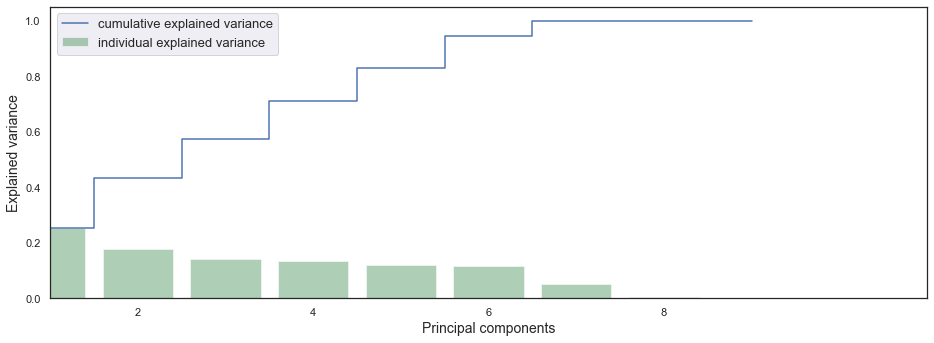

In [90]:
# to represent the amount of variance explained by each of the components:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13)

#### Create customer categories
At this point, I define clusters of clients from the standardized matrix that was defined earlier and using the k-means algorithm fromscikit-learn. I choose the number of clusters based on the silhouette score and I find that the best score is obtained with 9 clusters:

In [94]:
# In order to define (approximately) the number of clusters that best represents the data
# to use the silhouette score:
for n_clusters in range(3,15):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.1649526356450478
For n_clusters = 4 The average silhouette_score is : 0.18169086431286943
For n_clusters = 5 The average silhouette_score is : 0.18736332136029432
For n_clusters = 6 The average silhouette_score is : 0.18872010315496232
For n_clusters = 7 The average silhouette_score is : 0.19986249971124306
For n_clusters = 8 The average silhouette_score is : 0.21036257537141528
For n_clusters = 9 The average silhouette_score is : 0.22150498894870635
For n_clusters = 10 The average silhouette_score is : 0.2188313898594152
For n_clusters = 11 The average silhouette_score is : 0.20109884092902386
For n_clusters = 12 The average silhouette_score is : 0.20502421723028155
For n_clusters = 13 The average silhouette_score is : 0.19891304142792351
For n_clusters = 14 The average silhouette_score is : 0.1948188233295756


In [95]:
# n_clusters = 11
n_clusters = 9
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.221


In [96]:
# to look at the number of customers in each cluster:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['number of clients']).T

,0,4,1,8,2,3,7,5,6
number of clients,585,458,362,285,178,152,17,15,6


__a / Report via the PCA__

There is a certain disparity in the sizes of different groups that have been created. Hence I will now try to understand the content of these clusters in order to validate (or not) this particular separation. At first, I use the result of the PCA:

In [97]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

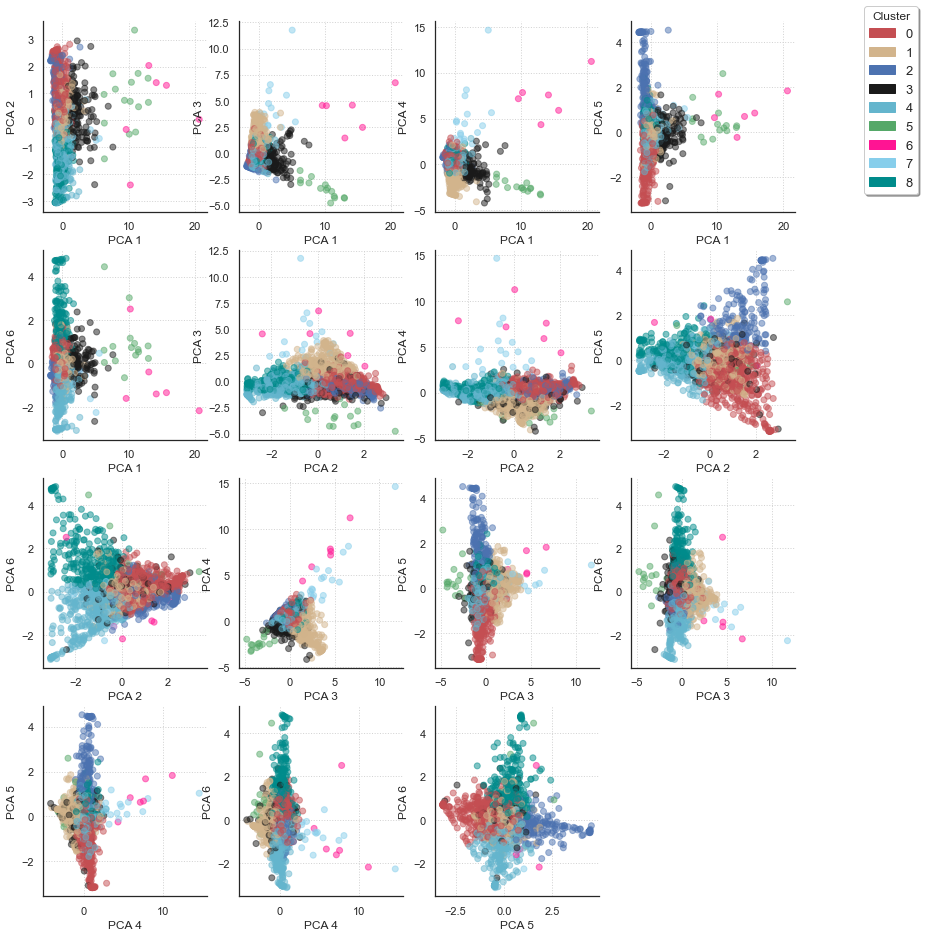

In [102]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan',
                   9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,15))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,4,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 16: break
    if increment == 16: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', 
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure) #facecolor = 'lightgrey',

plt.tight_layout()

__b/ Score of the silhouette intra-cluster__

As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters:

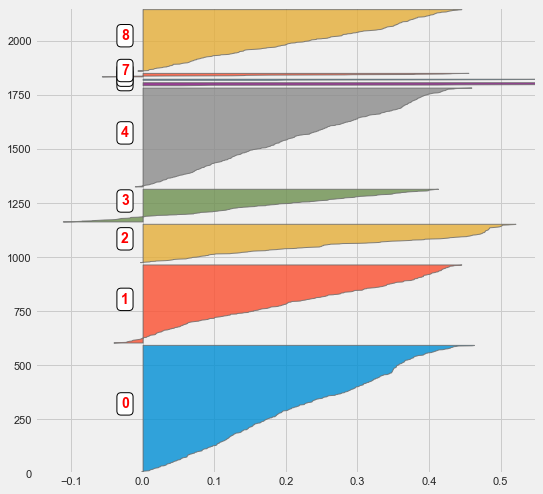

In [103]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silhouette scores 
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, 
                           clusters_clients)

__c/ Customers morphotype__

At this stage, I have verified that the different clusters are indeed disjoint (at least, in a global way). It remains to understand the habits of the customers in each cluster. To do so, I start by adding to the selected_customers dataframe a variable that defines the cluster to which each client belongs:

In [104]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, I average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. I also determine the number of clients in each group (variable ** size **):

In [117]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])

#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')
# merged_df

number of customers: 2058


Finally, I re-organize the content of the dataframe by ordering the different clusters: first, in relation to the amount spent in each product category and then, according to the total amount spent:

In [124]:
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 40].index.values[0])

liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]

merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,4.0,1.700873,271.931118,419.321489,338.333599,599.322166,49.474499,12.645508,15.210651,8.385903,14.306858,458
1,8.0,1.701754,245.245404,355.066561,296.851837,543.995053,20.272798,44.260230,13.854060,8.904960,12.717244,285
2,0.0,1.861538,269.835624,394.584515,327.855769,609.481557,15.688631,8.345516,46.142961,15.611347,14.229236,585
3,2.0,1.483146,237.763876,289.574382,260.718324,389.182416,9.650712,4.268044,17.227251,58.670142,10.183851,178
4,1.0,2.060773,281.297541,434.346657,353.996662,767.889945,13.371973,8.007533,18.461341,9.888031,50.294233,362
5,3.0,1.467105,1051.613487,1506.860724,1240.910066,2029.137895,24.308479,12.924295,27.019366,13.031383,22.716922,152
6,5.0,1.000000,3762.531333,3762.531333,3762.531333,3762.531333,25.036367,20.854140,21.315807,17.122452,15.671234,15
7,7.0,18.529412,105.031176,2530.976471,632.794271,10979.246471,25.287613,17.270287,21.552490,11.867079,24.056488,17
8,6.0,12.666667,71.353333,19052.918333,4562.130528,54109.740000,26.274853,20.318717,26.015281,9.211459,18.179690,6


__d / Customers morphology garphical representation__

Finally, I created a representation of the different morphotypes. To do this, I define a class to create "Radar Charts" (which has been adapted from this [kernel](https://www.kaggle.com/yassineghouzam/don-t-know-why-employees-leave -read-this)):

In [142]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)


In [131]:
merged_df

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,size
0,4.0,1.700873,271.931118,419.321489,338.333599,599.322166,49.474499,12.645508,15.210651,8.385903,14.306858,27.694323,41.355895,458
1,8.0,1.701754,245.245404,355.066561,296.851837,543.995053,20.272798,44.260230,13.854060,8.904960,12.717244,30.635088,45.371930,285
2,0.0,1.861538,269.835624,394.584515,327.855769,609.481557,15.688631,8.345516,46.142961,15.611347,14.229236,29.147009,47.282051,585
3,2.0,1.483146,237.763876,289.574382,260.718324,389.182416,9.650712,4.268044,17.227251,58.670142,10.183851,29.707865,40.033708,178
4,1.0,2.060773,281.297541,434.346657,353.996662,767.889945,13.371973,8.007533,18.461341,9.888031,50.294233,26.502762,46.209945,362
5,3.0,1.467105,1051.613487,1506.860724,1240.910066,2029.137895,24.308479,12.924295,27.019366,13.031383,22.716922,26.980263,37.269737,152
6,5.0,1.000000,3762.531333,3762.531333,3762.531333,3762.531333,25.036367,20.854140,21.315807,17.122452,15.671234,38.533333,38.533333,15
7,7.0,18.529412,105.031176,2530.976471,632.794271,10979.246471,25.287613,17.270287,21.552490,11.867079,24.056488,3.117647,76.823529,17
8,6.0,12.666667,71.353333,19052.918333,4562.130528,54109.740000,26.274853,20.318717,26.015281,9.211459,18.179690,11.666667,73.000000,6


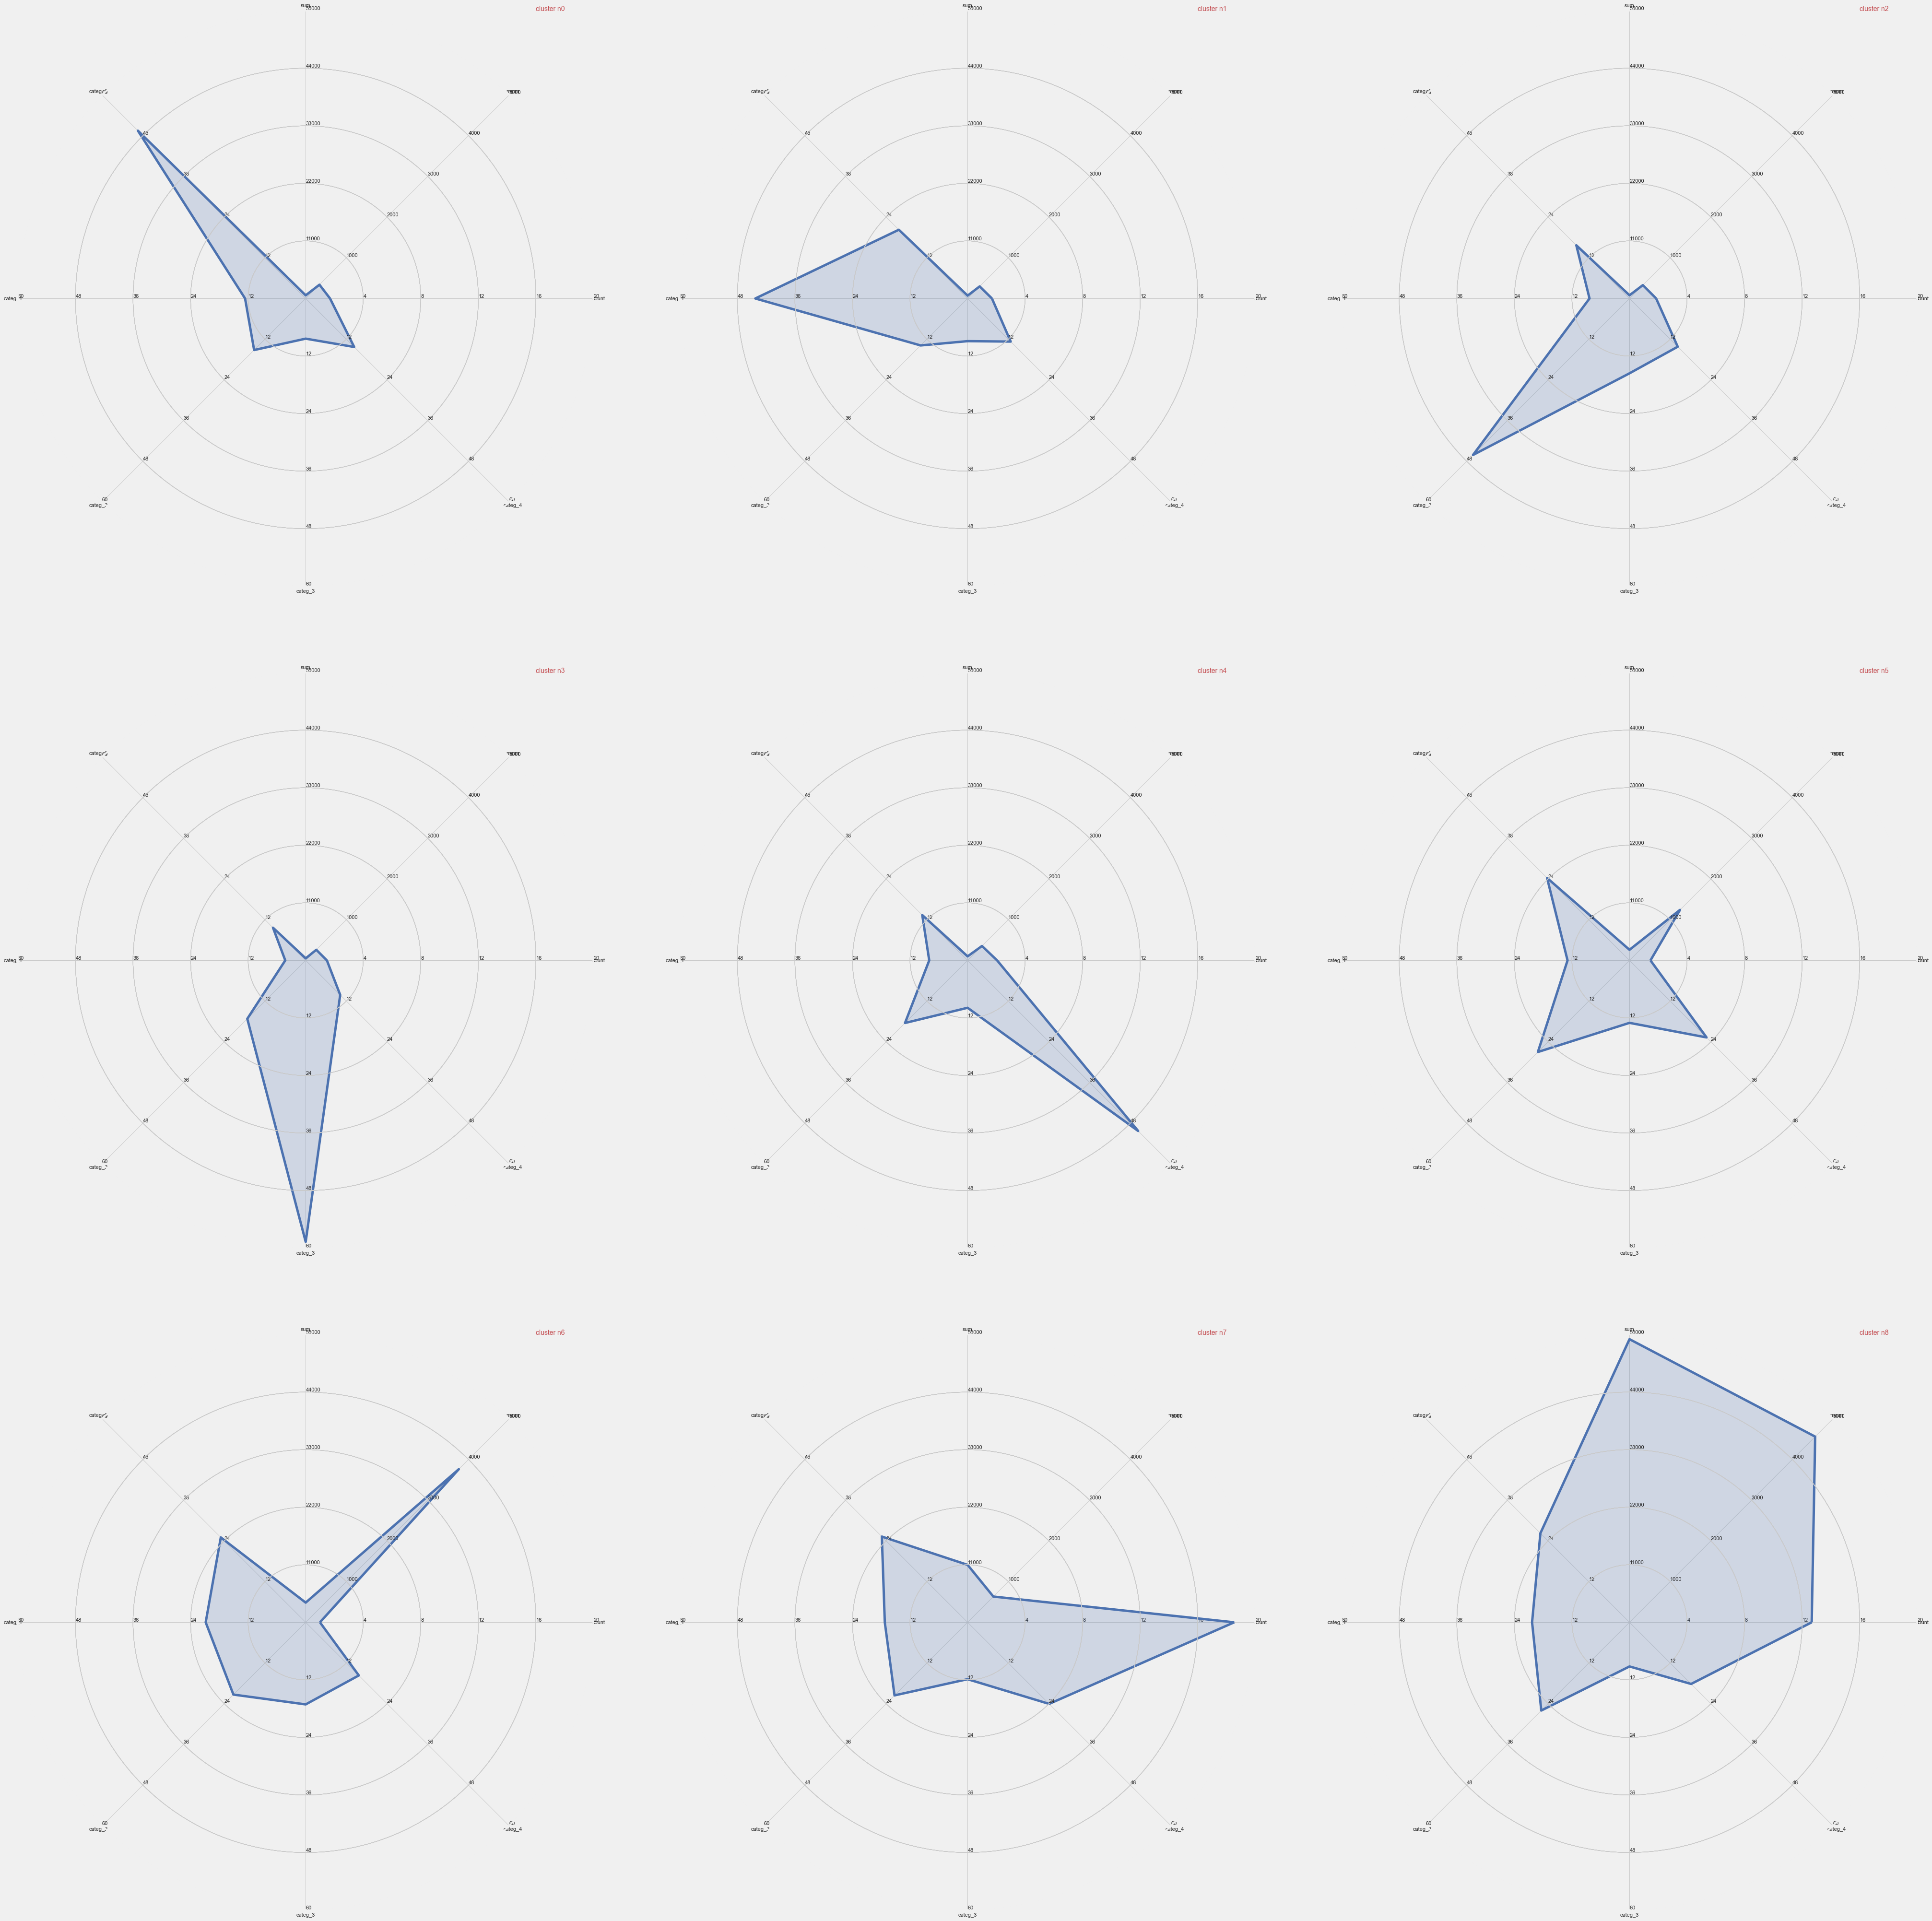

In [144]:
# This allows to have a global view of the content of each cluster:
fig = plt.figure(figsize=(50,50))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 20], [0.01, 5000], [0.01, 55000], [0.01, 60], [0.01, 60], [0.01, 60], [0.01, 60], [0.01, 60]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# index  = [0, 1, 2, 3, 4, 5, 6, 7, 8]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])  
    #print (data)
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=5.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster n{}'.format(index[ind]), color = 'r')
    ind += 1 

It can be seen, for example, that the first 5 clusters correspond to a strong preponderance of purchases in a particular category of products. Other clusters will differ from basket averages (** mean ), the total sum spent by the clients ( sum ) or the total number of visits made ( count **).

## Classification of customers

In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section. The objective is to make this classification possible at the first visit. To fulfill this objective, I will test several classifiers implemented in scikit-learn. First, in order to simplify their use, I define a class that allows to interface several of the functionalities common to these different classifiers:

In [145]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

Since the goal is to define the class to which a client belongs and this, as soon as its first visit, I only keep the variables that describe the content of the basket, and do not take into account the variables related to the frequency of visits or variations of the basket price over time:

In [146]:
selected_customers.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,cluster
0,12347.0,1,584.91,584.91,584.91,584.91,33.579525,16.720521,18.755022,10.480245,20.464687,59,59,4
1,12348.0,1,310.00,310.00,310.00,310.00,12.903226,0.000000,87.096774,0.000000,0.000000,5,5,0
2,12352.0,2,266.25,366.25,316.25,632.50,56.671937,24.561265,16.110672,0.000000,2.656126,2,10,4
3,12358.0,1,484.86,484.86,484.86,484.86,19.593285,66.287176,10.469001,0.000000,3.650538,80,80,8
4,12360.0,1,534.70,534.70,534.70,534.70,36.955302,0.000000,12.537872,8.857303,41.649523,42,42,1


In [147]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

In [148]:
# to split the dataset in train and test sets:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

### Support Vector Machine Classifier (SVC)
The first classifier I use is the SVC classifier. In order to use it, I create an instance of the Class_Fit class and then callgrid_search(). When calling this method, I provide as parameters:
- the hyperparameters for which I will seek an optimal value
- the number of folds to be used for cross-validation

In [149]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)
svc.grid_fit(X = X_train, Y = Y_train)

In [150]:
# to test the quality of the prediction with respect to the test data:
svc.grid_predict(X_test, Y_test)

Precision: 79.13 % 


#### Confusion matrix
The accuracy of the results seems to be correct. Nevertheless, let us remember that when the different classes were defined, there was an imbalance in size between the classes obtained. In particular, one class contains around 40% of the clients. It is therefore interesting to look at how the predictions and real values compare to the breasts of the different classes. This is the subject of the confusion matrices and to represent them, I use the code of the sklearn documentation:

In [151]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
   
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


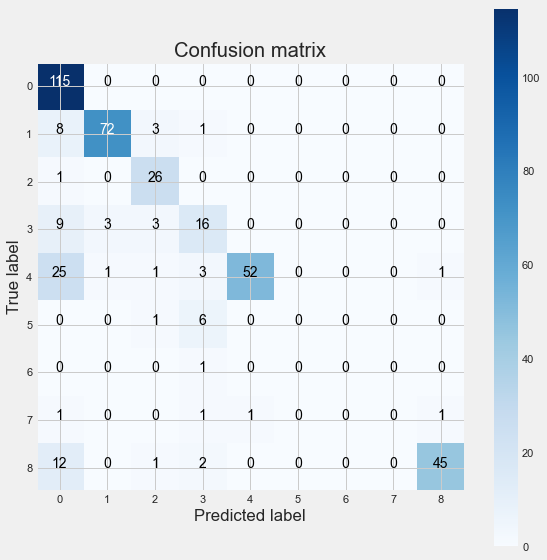

In [152]:
class_names = [i for i in range(9)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

#### Learning curve
A typical way to test the quality of a fit is to draw a learning curve. 
In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over- or under-fitting. 
This also shows to which extent the mode could benefit from a larger data sample. 
In order to draw this curve, I use the [scikit-learn documentation code again](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr- self-examples-model-selection-pad-learning-curve-py)

In [153]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

/Users/hongyingyue/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/hongyingyue/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/hongyingyue/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/hongyingyue/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/hongyingyue/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

/Users/hongyingyue/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/hongyingyue/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/hongyingyue/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/hongyingyue/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/hongyingyue/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

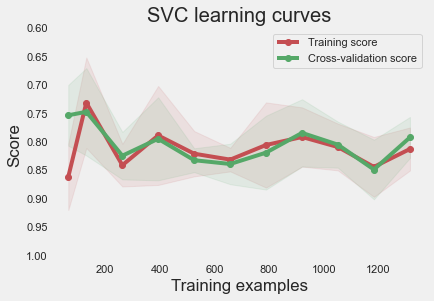

In [154]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

On this curve, we can see that the train and cross-validation curves converge towards the same limit when the sample size increases. This is typical of modeling with low variance and proves that the model does not suffer from overfitting. Also, we can see that the accuracy of the training curve is correct which is synonymous of a low bias. Hence the model does not underfit the data.

### Logistic Regression
I now consider the logistic regression classifier. As before, I create an instance of the Class_Fit class, adjust the model on the training data and see how the predictions compare to the real values:

In [155]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 93.93 % 


/Users/hongyingyue/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hongyingyue/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

/Users/hongyingyue/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hongyingyue/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

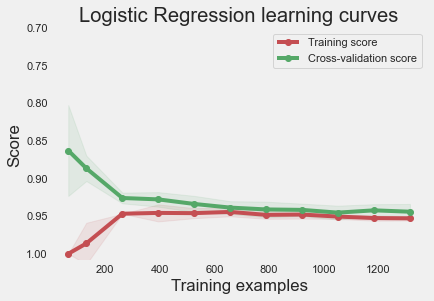

In [156]:
# to plot the learning curve
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### k-Nearest Neighbors

In [157]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 83.98 % 


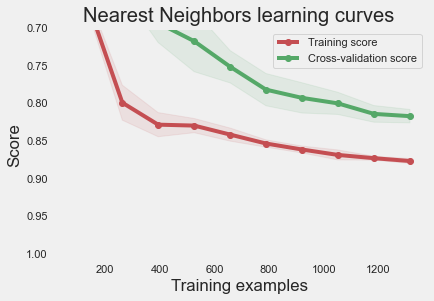

In [158]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Decision Tree

In [159]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 85.19 % 


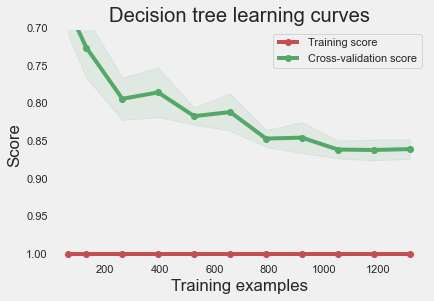

In [160]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Random Forest

In [161]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 90.78 % 


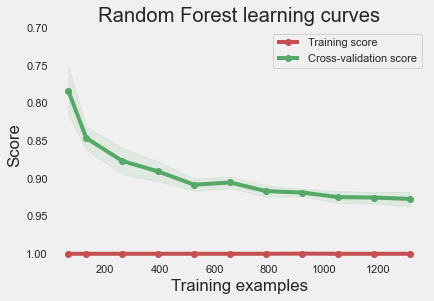

In [162]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### AdaBoost Classifier

In [163]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 43.45 % 


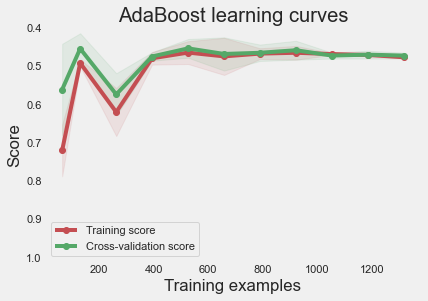

In [164]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Gradient Boosting Classifier

In [165]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 91.50 % 


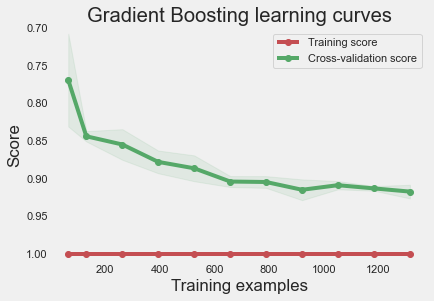

In [166]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Best approach
Let's vote !

Finally, the results of the different classifiers presented in the previous sections can be combined to improve the classification model. This can be achieved by selecting the customer category as the one indicated by the majority of classifiers. To do this, I use the VotingClassifier method of the sklearn package. As a first step, I adjust the parameters of the various classifiers using the best parameters previously found:

In [167]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

In [168]:
# to define a classifier that merges the results of the various classifiers:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')    

In [169]:
# to train it:
votingC = votingC.fit(X_train, Y_train)

Finally, we can create a prediction for this model:

In [170]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 91.26 % 


Note that when defining the votingC classifier, I only used a sub-sample of the whole set of classifiers defined above and only retained the Random Forest, the k-Nearest Neighbors and the Gradient Boosting classifiers. In practice, this choice has been done with respect to the performance of the classification carried out in the next section.

### Test predictions
In the previous section, a few classifiers were trained in order to categorize customers. Until that point, the whole analysis was based on the data of the first 3 months. 

In this section, I test the model the last two months of the dataset, that has been stored in the set_test dataframe:

In [177]:
basket_price = set_test.copy(deep = True)

In a first step, I regroup reformattes these data according to the same procedure as used on the training set. However, I am correcting the data to take into account the difference in time between the two datasets and weights the variables ** count ** and ** sum ** to obtain an equivalence with the training set:

In [178]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)

#_______________________
# Correcting time range
transactions_per_user['count'] = 1.5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.0,3.0,224.82,1294.32,759.57,2278.710,31.282173,3.659966,18.675040,14.039522,32.343299
1,12349.0,1.5,1757.55,1757.55,1757.55,2636.325,36.508207,21.234104,26.506216,4.513101,11.238372
2,12352.0,1.5,311.73,311.73,311.73,467.595,37.612678,17.290604,34.420813,6.672441,4.003465
3,12356.0,1.5,58.35,58.35,58.35,87.525,100.000000,0.000000,0.000000,0.000000,0.000000
4,12357.0,1.5,6207.67,6207.67,6207.67,9311.505,35.152642,25.189000,18.601182,5.341134,15.716042


Then, I convert the dataframe into a matrix and retain only variables that define the category to which consumers belong. At this level, I recall the method of normalization that had been used on the training set:

In [179]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
matrix_test = transactions_per_user[list_cols].values
scaled_test_matrix = scaler.transform(matrix_test)

Each line in this matrix contains a consumer's buying habits. At this stage, it is a question of using these habits in order to define the category to which the consumer belongs. These categories have been established in Section 4. 

__At this stage, it is important to bear in mind that this step does not correspond to the classification stage itself.__ Here, we prepare the test data by defining the category to which the customers belong. However, this definition uses data obtained over a period of 2 months (via the variables **count**, **min**, **max** and **sum**). The classifier defined in Section 5 uses a more restricted set of variables that will be defined from the first purchase of a client.

Here it is a question of using the available data over a period of two months and using this data to define the category to which the customers belong. Then, the classifier can be tested by comparing its predictions with these categories. In order to define the category to which the clients belong, I recall the instance of the kmeans method used in section 4. The predict method of this instance calculates the distance of the consumers from the centroids of the 9 client classes and the smallest distance will define the belonging to the different categories:

In [180]:
Y = kmeans.predict(scaled_test_matrix)

# in order to prepare the execution of the classifier, it is sufficient to select the variables on which it acts:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]

In [181]:
# to examine the predictions of the different classifiers that have been trained earlier
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 80.79 % 
______________________________ 
Logostic Regression
Precision: 92.00 % 
______________________________ 
k-Nearest Neighbors
Precision: 81.46 % 
______________________________ 
Decision Tree
Precision: 84.75 % 
______________________________ 
Random Forest
Precision: 91.30 % 
______________________________ 
Gradient Boosting
Precision: 91.49 % 


Finally, as anticipated in revised approach, it is possible to improve the quality of the classifier by combining their respective predictions. At this level, I chose to mix Random Forest, Gradient Boosting and k-Nearest Neighbors predictions because this leads to a slight improvement in predictions:

In [182]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 91.89 % 
